imports

In [81]:
import csv
import numpy as np
import sklearn as sk
import matplotlib.pylab as plt
%matplotlib inline
import copy as cp
import pickle
import pandas as pd
import os.path
import seaborn as sns
from progressbar import ProgressBar

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import re
import sys
import tarfile

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans

def plotImage(matrix):  # appropriate for weights
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.ocean,
        extent=[matrix.min(), matrix.max(), matrix[0].min(), matrix[0].max()])
    plt.colorbar()
    plt.show()

function for reading feature extracted file and clustering

In [3]:
def import_features(features_file_path, labels_file_path):
    with open(features_file_path, 'rb') as f:
        reader = csv.reader(f, delimiter=',')
        mylist = list(reader)
        data = np.asanyarray(mylist).astype(float)
    labels = []
    with open(labels_file_path,'rU') as f:
        rows = csv.DictReader(f)
        for row in rows:
            labels.append(row['Class'])
    labels = np.asarray(labels).astype(int)
    return (data,labels)

functions for distance metrics

In [34]:
from scipy.spatial.distance import pdist, squareform

def compute_all_distances(X, metric='euclidean'):
    return squareform(pdist(X, metric=metric))

def representation_metric_all_samples(dist, y):
    assert len(dist.shape) == 2 and dist.shape[0] == dist.shape[1], (
        'Distance matrix is not square!')
    within_group_distance = 0.
    between_group_distance = 0.
    num_within, num_between = 0, 0
    labels = np.unique(y)
    for label in labels:
        label_mask = y==label
        
        within_group_distance += dist[label_mask].T[label_mask].sum()
        between_group_distance += dist[label_mask].T[~label_mask].sum()
        
        num_within += label_mask.sum() * (label_mask.sum()-1) / 2
        num_between += label_mask.sum() * (~label_mask).sum()
    
    return (between_group_distance / within_group_distance 
            * num_within / num_between 
            * 2)

In [35]:
def compute_representation_metric(X,y,metric='euclidean'):
    return representation_metric_all_samples(compute_all_distances(X, metric),y)

Toy Examples

In [166]:
X = np.array([[1], [10], [3], [5], [1], [4]])
y = np.array([1, 2, 1, 1, 3, 3])
d = compute_all_distances(X)
representation_metric_all_samples(d, y)

1.5537190082644627

In [167]:
X = np.array([[1], [10], [3]])
y = np.array([1, 2, 1])
d = compute_all_distances(X)
representation_metric_all_samples(d, y)

4.0

# Loading Extracted Features

Images

In [6]:
(data,labels) = import_features("features/images/pool_3:0.csv", "datasets/images/trainLabels.csv")

Metrics For Clustering in Images

In [7]:
compute_representation_metric(data,labels)

1.4511750233119622

In [32]:
def permute_labels(y):
    ls =cp.copy(y)
    np.random.shuffle(ls)
    return ls

In [19]:
metric_for_permuted = [compute_representation_metric(data,permute_labels(labels)) for i in range(1000)]

In [24]:
max(metric_for_permuted)

1.005965101732047

In [33]:
def compute_clustering_stats(data,labels,num_iter):
    stats = {}
    true = compute_representation_metric(data,labels)
    metric_for_permuted = [compute_representation_metric(data,permute_labels(labels)) for i in range(num_iter)]
    metric_for_permuted_with_true = np.asarray(metric_for_permuted+[true])
    p = float((metric_for_permuted_with_true>=true).sum())/num_iter
    stats["true"] = true
    stats["metric"] = metric_for_permuted
    stats["p"] = p
    return stats
    
    
    


In [40]:
stats = compute_clustering_stats(data,labels,10)
stats['p']

T-SNE 

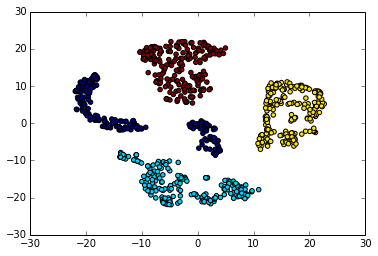

In [157]:
# T-SNE
points = tsne_model.fit_transform(data)
plt.scatter(points[:,0],points[:,1], c=labels)

In [158]:
# K-Means cluters
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(data)
r = data[np.where(kmeans_model.labels_ == 2)]
s = np.mean(r,axis=1)

In [159]:
print(sk.metrics.adjusted_rand_score(kmeans_model.labels_,labels))
print(sk.metrics.cluster.adjusted_mutual_info_score(kmeans_model.labels_,labels))
print(sk.metrics.normalized_mutual_info_score(kmeans_model.labels_,labels))
print(sk.metrics.adjusted_rand_score([0, 0, 1, 1] , [1, 1, 0, 0]))
print(sk.metrics.adjusted_rand_score([1, 1, 0, 0] , [1, 1, 0, 0]))

0.4105666448
0.543797423271
0.575966199505
1.0
1.0


Emotion

In [45]:
(data,labels) = import_features("features/emotion/pool_3:0.csv", "datasets/emotion/samples.csv")

Metrics For Clustering in Emotion

In [171]:
representation_metric_all_samples(compute_all_distances(data), labels)

1.0085323129059911

In [46]:
stats = compute_clustering_stats(data,labels,10)
stats['p']

0.1

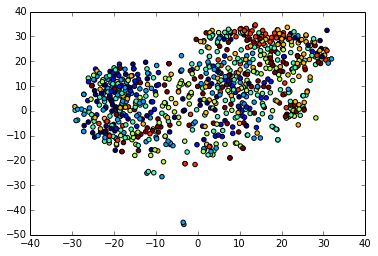

In [154]:
# T-sne on emotion data (very first result)
points = tsne_model.fit_transform(data)
plt.scatter(points[:,0],points[:,1], c=labels)

In [ ]:
#(data,labels) = import_features("features/emotion/pool_2:0.csv", "datasets/emotion/samples.csv")
#points = tsne_model.fit_transform(data)
#plt.scatter(points[:,0],points[:,1], c=labels)

In [161]:
# K-Means cluters
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(data)
r = data[np.where(kmeans_model.labels_ == 2)]
s = np.mean(r,axis=1)

In [162]:
print(sk.metrics.adjusted_rand_score(kmeans_model.labels_,labels))
print(sk.metrics.cluster.adjusted_mutual_info_score(kmeans_model.labels_,labels))
print(sk.metrics.normalized_mutual_info_score(kmeans_model.labels_,labels))

0.0320160021274
0.0516946864751
0.0707105053


DRIVER

In [80]:
def import_labels(labels_file_path):
    with open(labels_file_path,'rU') as f:
        return  np.asanyarray(pd.read_csv(f).Class).astype(int)

In [24]:
# function to create list of images
def dataset_gen(samplesPath, data_dir):
    with open(samplesPath,'rU') as f:
        return [getImage(data_dir,im) for im in pd.read_csv(f).Id]
    
    
def getImage(data_dir,im):
    filepath = data_dir+'/'+im+'.jpg'
    if not os.path.exists(filepath):
        print('File does not exist %s', filepath)
    return open(filepath, 'rb').read()

Tensorflow things

In [28]:
from six.moves import urllib
import tensorflow as tf

In [29]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string(
    'model_dir', '/tmp/imagenet',
    """Path to classify_image_graph_def.pb, """
    """imagenet_synset_to_human_label_map.txt, and """
    """imagenet_2012_challenge_label_map_proto.pbtxt.""")
tf.app.flags.DEFINE_string('image_file', '',
                           """Absolute path to image file.""")
tf.app.flags.DEFINE_integer('num_top_predictions', 5,
                            """Display this many predictions.""")

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long

class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
    
#print all op names
def print_ops():
    create_graph()
    with tf.Session() as sess:
        ops = sess.graph.get_operations()
        for op in ops:
            print(op.name)

In [69]:
def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath,
                                             reporthook=_progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

In [87]:
# function to generate features
def generateFeatures(layer_name ,dataset):
    """Generate and save features as csv for a particular layer and dataset.
    Keyword arguments:
    layer_name -- String: the name of the tensor, ex 'pool_3:0'
    dataset -- Generator: an iterator over the image dataset
    """ 
    create_graph()
    all_features = []
    with tf.Session() as sess:
        layer = sess.graph.get_tensor_by_name(layer_name)
        for image_data in dataset:
            features = sess.run(layer,{'DecodeJpeg/contents:0': image_data})
            features = np.reshape(features,(np.product(features.shape)))
            all_features.append(features)
    return np.asanyarray(all_features).astype(float)


In [72]:
def plot_TSNE(data,labels):
    points = tsne_model.fit_transform(data)
    df = pd.DataFrame(data =np.column_stack([points,labels]), columns = ["x","y","class"])
    sns.lmplot("x", "y", data=df, hue='class', fit_reg=False)

In [88]:
def run(layers, datasets, labels):
    for i,dataset in enumerate(datasets):
        layer_results = {}
        classes = labels[i]
        for layer in layers:
            print("Generating features for dataset "+str(i)+" layer "+layer)
            features = generateFeatures(layer, dataset)
            plot_TSNE(features,classes)
            print("Generating stats for dataset "+str(i)+" layer "+layer)
            stats = compute_clustering_stats(features,classes,10)
            layer_results[layer] = stats
            print("P-value for dataset "+str(i)+" layer "+layer+ " : "+str(stats["p"]))
            del features
        print("Stats for dataset "+str(i))
        del dataset
        #plot the stats for the dataset, each layer will have a boxplot for the metric with permuted labels and true value



In [89]:
layers = ["pool_3:0"]
datasets = [dataset_gen("datasets/synthetic/trainLabels.csv","datasets/synthetic")]
labels = [import_labels("datasets/synthetic/trainLabels.csv")] 

In [ ]:
run(layers, datasets, labels)

Generating features for dataset 0 layer pool_3:0
